In [5]:
!pip install -i https://test.pypi.org/simple/ invertedai==0.0.9.dev0

/usr/bin/pip:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import load_entry_point
Looking in indexes: https://test.pypi.org/simple/
ERROR: Error checking for conflicts.
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py", line 3109, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py", line 2902, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/pkg_resources/_vendor/packaging/requirements.py", line 35, in __init__
    parsed = _parse_requirement(requirement_string)
  File "/usr/local/lib/python3.8/dist-packages/pkg_resources/_vendor/packaging/_parser.py", line 64, in parse_requiremen

In [1]:
import sys
sys.path.insert(0, "..")

import IPython
from IPython.display import display, Image, clear_output
from ipywidgets import interact

import matplotlib.pyplot as plt
import imageio
import numpy as np
import cv2 
import invertedai as iai
from IPython.utils import io

import csv
import pickle
import random
import time

In [2]:
# API key:
iai.add_apikey("WyiIbfxsbPak3HpP2JVNma7jfQQIrflxa4AUS6mC")

# Grab Randomly Selected Collision Log

In [480]:
import os

#Get a random pickle log to process
data_high_level_path = os.path.join(os.getcwd(),"blame_example_logs")
loc_dir_list = os.listdir(data_high_level_path) #Acquire list of location directories
loc_dir_name = loc_dir_list[random.randint(0,len(loc_dir_list)-1)] #Name of the directory is the name of the map location
log_dir_path = os.path.join(os.path.join(data_high_level_path,loc_dir_name),"collision")
log_dir_list = os.listdir(log_dir_path)
log_file_name = log_dir_list[random.randint(0,len(log_dir_list)-1)]
log_file_path = os.path.join(log_dir_path,log_file_name)

with open(log_file_path, 'rb') as f:
    log_dict = pickle.load(f) #Use pickle library to unpack serialized log data

#Acquire the initial conditions from the log data
#If no traffic light data available, create a list of None's
if not log_dict["traffic_light_states"]: #list is empty, NO TRAFFIC LIGHT DATA
    traffic_light_states = [None for _ in range(len(log_dict["agent_states"]))]
else:
    traffic_light_states = log_dict["traffic_light_states"]

agent_states = log_dict["agent_states"]
agent_attributes = log_dict["agent_attributes"]

#Get the location name and initialize the Scene Plotter
location = "iai:"+loc_dir_name #Create formatted name as input as input into IAI Location
location_info_response = iai.location_info(location=location)
rendered_static_map = location_info_response.birdview_image.decode()
scene_plotter = iai.utils.ScenePlotter(
    rendered_static_map, 
    location_info_response.map_fov, 
    (location_info_response.map_center.x, location_info_response.map_center.y), 
    location_info_response.static_actors
)
print(f"Selected file name is {log_file_name} at location {location}.")

Selected file name is blame_demo_logs_data_1689190366.pkl at location iai:terminal_and_quebec.


# Determine IF Collision has Occurred and Which Agent is to Blame

In [481]:
collision_detection_response = iai.blame(
    location=location,
    candidate_agents=[0, 0],
    agent_state_history=agent_states,
    agent_attributes=agent_attributes,
    traffic_light_state_history=None if not traffic_light_states[0] else traffic_light_states,
    get_birdviews=False,
    detect_collisions=True
)

#Parse the blame data to find which agents are in collision
collision_agents = set()
blamed_agents = set()
collision_start_time = float('inf')
collision_end_time = 0
for col in collision_detection_response.blamed_collisions:
    for agent in col[0]:
        collision_agents.add(agent)
    for agent in col[2]:
        blamed_agents.add(agent)
    collision_start_time = min(collision_start_time,col[1][0])
    collision_end_time = max(collision_end_time,col[1][1])
collision_agents = list(collision_agents)
blamed_agents = list(blamed_agents)

#Populate the scene plotter with a representation of the whole state at each time step
scene_plotter.initialize_recording(
    agent_states[collision_start_time], 
    agent_attributes, 
    traffic_light_states[collision_start_time],
    conditional_agents = collision_agents
)
for j, (st,tls) in enumerate(zip(agent_states[collision_start_time:collision_end_time],traffic_light_states[collision_start_time:collision_end_time])):
    scene_plotter.record_step(st, tls)
    clear_output(wait=True)
        
print("All agents involved in collisions: ", collision_agents)
print("Agents blamed for the collisions: ", blamed_agents)

All agents involved in collisions:  [8, 15]
Agents blamed for the collisions:  [8]


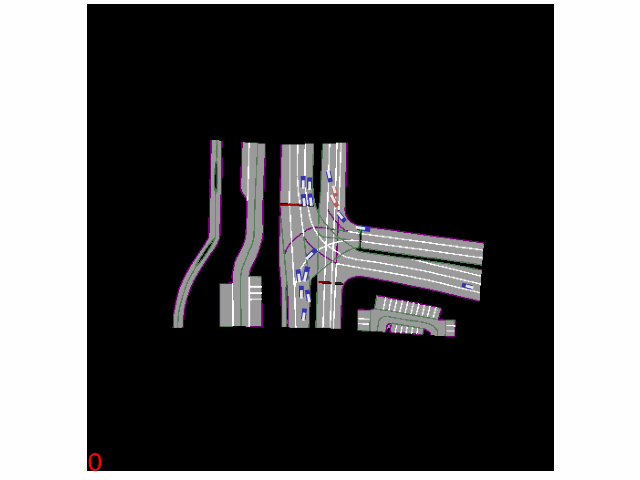

<Figure size 640x480 with 0 Axes>

In [482]:
#Create the figure and populate the gif
gif_name = 'collision_scene.gif'
fig, ax = plt.subplots(constrained_layout=True, figsize=(50, 50))
ax.set_axis_off()

scene_plotter.animate_scene(
    output_name=gif_name,
    ax=ax,
    numbers=False,
    direction_vec=True,
    velocity_vec=False,
    plot_frame_number=True,
)
plt.clf()
clear_output()
display(Image(gif_name, width=1000, height=1000))

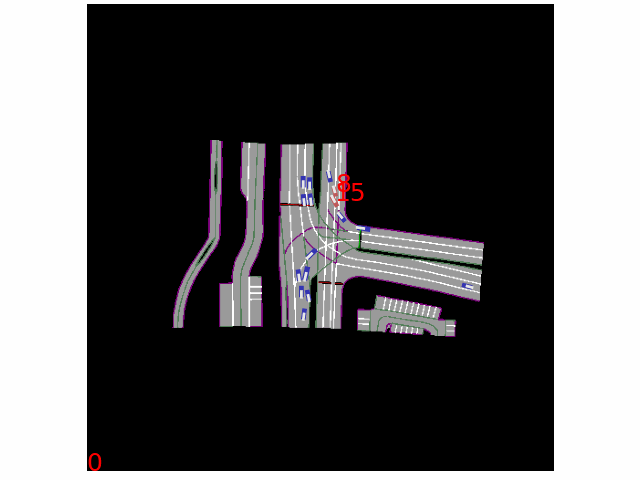

<Figure size 640x480 with 0 Axes>

In [483]:
#Create the figure and populate the gif
gif_name = 'collision_scene_with_numbers.gif'
fig, ax = plt.subplots(constrained_layout=True, figsize=(50, 50))
ax.set_axis_off()

scene_plotter.animate_scene(
    output_name=gif_name,
    ax=ax,
    numbers=collision_agents,
    direction_vec=True,
    velocity_vec=False,
    plot_frame_number=True,
)
plt.clf()
clear_output()
display(Image(gif_name, width=1000, height=1000))

# Determine The Reason And Confidence Score of Blamed Collisions

In [484]:
#Parse the blame data to find which agents are in collision
blamed_agents = dict()
gif_name_list = []
for i, col in enumerate(collision_detection_response.blamed_collisions):
    blame_response = iai.blame(
        location=location,
        candidate_agents=list(col[0]),
        agent_state_history=agent_states[collision_start_time:collision_end_time],
        traffic_light_state_history=None if not traffic_light_states[0] else traffic_light_states[collision_start_time:collision_end_time],
        agent_attributes=agent_attributes,
        get_reasons=True,
        get_confidence_score=True,
        get_birdviews=False,
        detect_collisions=False
    )
    
    
    #Populate the scene plotter with a representation of the whole state at each time step
    scene_plotter.initialize_recording(
        agent_states[collision_start_time], 
        agent_attributes, 
        traffic_light_states[collision_start_time],
        conditional_agents = collision_agents
    )
    for j, (st,tls) in enumerate(zip(agent_states[col[1][0]:col[1][1]],traffic_light_states[col[1][0]:col[1][1]])):
        scene_plotter.record_step(st, tls)
        clear_output(wait=True)
        
    #Create the figure and populate the gif
    gif_name = f'collision_scene_with_blame{i}.gif'
    fig, ax = plt.subplots(constrained_layout=True, figsize=(50, 50))
    ax.set_axis_off()

    scene_plotter.animate_scene(
        output_name=gif_name,
        ax=ax,
        numbers=list(col[0]),
        direction_vec=True,
        velocity_vec=False,
        plot_frame_number=True,
    )
    plt.clf()
    
    blamed_agents[col[0]] = {}
    blamed_agents[col[0]]["time"] = list(col[1])
    blamed_agents[col[0]]["result"] = blame_response.blamed_result
    blamed_agents[col[0]]["reasons"] = blame_response.reasons
    blamed_agents[col[0]]["confidence_score"] = blame_response.confidence_score
    blamed_agents[col[0]]["gif_name"] = gif_name
        


<Figure size 640x480 with 0 Axes>

Agents in collision:  [8, 15]
List of blamed agents if any:  (15,)
Reasons per blamed agents if any:  {15: ['side_swiping']}
Confidence in blame decision:  0.6264671087265015


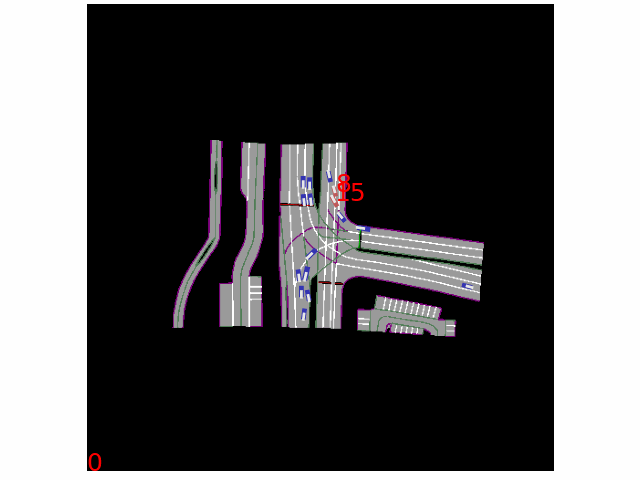

In [485]:
for agents, collision_data in blamed_agents.items():
    print("Agents in collision: ", list(agents))
    res = collision_data["result"]
    print("List of blamed agents if any: ", res)
    print("Reasons per blamed agents if any: ", collision_data["reasons"])
    print("Confidence in blame decision: ", collision_data["confidence_score"])
    display(Image(collision_data["gif_name"], width=1000, height=1000))